In [27]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

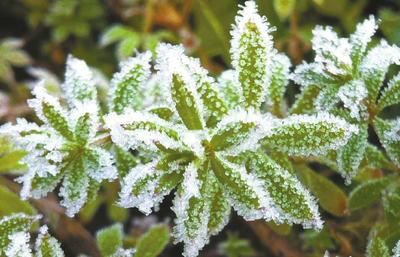

In [5]:
# Open one image from the dataset
path = 'dataset'
with Image.open('dataset/frost/3600.jpg') as img:
    display(img)

In [6]:
# Create ImageFolder Dataset
dataset = datasets.ImageFolder(path, transform=None)
dataset

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: dataset

In [7]:
classes = dataset.classes
print(classes)
print("\t")
print("Number of classes:", len(classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Number of classes: 11


## Split dataset into train, validation and test sets

In [8]:
# Split dataset into train and test
train_size_old = int(0.85 * len(dataset))
test_size = len(dataset) - train_size_old
train_data_old, test_data = torch.utils.data.random_split(dataset, [train_size_old, test_size])

# Split dataset to train and validation
train_size = int(0.85 * len(train_data_old))
validation_size = len(train_data_old) - train_size

train_data, validation_data = torch.utils.data.random_split(train_data_old, [train_size, validation_size])

## Define transforms for each set

In [9]:
# Define the normalization values for mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Apply transformation mechanism for each set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5,contrast=0.3,saturation=0.2,hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.dataset.transform = train_transform

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
validation_data.dataset.transform = val_transform

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_data.dataset.transform = test_transform

## Create data loaders for each set of data

In [10]:
batch = 32

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=True)

print("Training images available:", len(train_data))
print("\t")
print("Validation images available:", len(validation_data))
print("\t")
print("Testing images available:", len(test_data))

Training images available: 4957
	
Validation images available: 875
	
Testing images available: 1030


In [11]:
# Show one tensor from train data

train_data[0]

(tensor([[[-0.1486, -0.3541, -0.3883,  ..., -1.1932, -1.1760, -1.1760],
          [ 0.6392, -0.0287, -0.2856,  ..., -1.1589, -1.1589, -1.1589],
          [ 1.1700,  0.6563, -0.0458,  ..., -1.1589, -1.1589, -1.1418],
          ...,
          [ 0.5022,  0.5022,  0.5364,  ...,  0.9646,  1.1700,  0.9988],
          [ 0.5022,  0.5193,  0.5193,  ...,  0.9988,  1.0844,  1.1187],
          [ 0.4851,  0.5022,  0.5193,  ...,  1.1358,  1.2385,  0.9988]],
 
         [[ 0.1001, -0.0399, -0.0924,  ..., -0.5826, -0.5651, -0.5651],
          [ 0.8529,  0.2402, -0.0399,  ..., -0.5476, -0.5476, -0.5476],
          [ 1.3256,  0.8529,  0.1176,  ..., -0.5476, -0.5476, -0.5301],
          ...,
          [ 0.6078,  0.6078,  0.6429,  ...,  1.0105,  1.2206,  1.0630],
          [ 0.6078,  0.6254,  0.6254,  ...,  1.0805,  1.1506,  1.1856],
          [ 0.6078,  0.6254,  0.6254,  ...,  1.2206,  1.3081,  1.0455]],
 
         [[ 0.6531,  0.6356,  0.6182,  ...,  0.3742,  0.4091,  0.4265],
          [ 1.2805,  0.8099,

Class Indexes: [ 8  1  1  7 10  2  1  9  3  8  9  8  3  3  1  2  1  8  2  7 10  8  3 10
  4  8  1 10  9  5  3  9]
	
Sample image size: torch.Size([3, 224, 224])


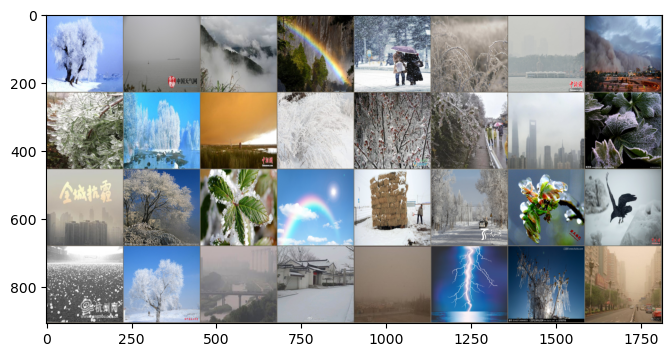

In [12]:
# Grab the first batch of 32 images

for images, labels in train_loader: 
    break

# Print the labels
print('Class Indexes:', labels.numpy())
print("\t")

im = make_grid(images, nrow=8)

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check one image shape
print("Sample image size:", images[10].shape)

## Define the Convolutional Network (custom CNN)

In [42]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)
        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Activation layer
        x = F.relu(self.conv1(x))
        # Pooling layer
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # Apply dropout after the first fully connected layer, 
        # since it has the most parameters and is more prone to overfitting
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # Output layer
        return F.log_softmax(x, dim=1)
    

# (224/2/2) = we divided 224 by the number of conv layers by calling pooling layers,
# which leaves us at 56 pixels per side

In [43]:
# Instantiate the model, define loss and optimization functions

CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(CNNmodel.parameters(), lr=0.001)
print(CNNmodel)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [44]:
# Looking at the trainable parameters
# sum of waits in whole CNN model

def count_parameters(model):
    print("Sum of waits of the model:")
    print("\t")
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
    
count_parameters(CNNmodel)

Sum of waits of the model:
	
     162
       6
     864
      16
 6021120
     120
   10080
      84
     924
      11
________
 6033387


## Train the model (custom CNN)

In [45]:
start_time = time.time()
epochs = 50

train_losses = []
train_correct = []
validation_losses = []
validation_correct = []

patience = 8
counter = 0
best_val_acc = 0
is_early_stop = False


for epoch in range(epochs):
    train_corr = 0
    validation_corr = 0
    
    # Run the training batches
    for batch, (images, labels) in enumerate(train_loader):

        # Apply the model for training
        outputs = CNNmodel(images)
        loss = criterion(outputs, labels)
 
        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        train_corr += (predicted == labels).sum()
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Append losses and correct predictions per epoch 
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    accuracy_train = round(train_corr.item() * 100 / 4957, 3)
    
    # Print each epoch results
    print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
          "Train accuracy:", accuracy_train, "%")



    
    # Run the validation batches
    CNNmodel.eval()
    
    with torch.no_grad():
        for batch, (images, labels) in enumerate(validation_loader):
            
            # Apply the model for validation
            outputs = CNNmodel(images)
            loss = criterion(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            validation_corr += (predicted == labels).sum()
            
        accuracy_val = round(validation_corr.item() * 100 / 875, 3)    
            
            
        # Early stopping
        if accuracy_val > best_val_acc:
            best_val_acc = accuracy_val
            counter = 0
            
            # Save model with best accuracy
            torch.save(CNNmodel.state_dict(), 'BestCustomCNNModel.pt')
            
        else:
            counter += 1
            
        # Check for early stopping after the validation loop    
        if counter >= patience:
            is_early_stop = True
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                  "Validation accuracy:", accuracy_val, "%")            
            print("Early stopping triggered. Training stopped.")
            break
            
            
    # Append losses and correct predictions per epoch             
    validation_losses.append(loss)
    validation_correct.append(validation_corr)
    
    
    if is_early_stop:
        break
    else:
        # Print each epoch results
        print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
              "Validation accuracy:", accuracy_val, "%")
        print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
        print("\t")
    

print("\n")
print("Duration:", round(time.time() - start_time, 1), "seconds")

Epoch: 1 Train loss: 1.647 Train accuracy: 36.635 %
Epoch: 1 Validation loss: 0.957 Validation accuracy: 52.457 %
best_val_acc: 52.457 counter: 0
	
Epoch: 2 Train loss: 1.055 Train accuracy: 60.137 %
Epoch: 2 Validation loss: 0.947 Validation accuracy: 65.829 %
best_val_acc: 65.829 counter: 0
	
Epoch: 3 Train loss: 0.972 Train accuracy: 69.155 %
Epoch: 3 Validation loss: 0.837 Validation accuracy: 69.714 %
best_val_acc: 69.714 counter: 0
	
Epoch: 4 Train loss: 0.674 Train accuracy: 77.85 %
Epoch: 4 Validation loss: 0.557 Validation accuracy: 71.543 %
best_val_acc: 71.543 counter: 0
	
Epoch: 5 Train loss: 0.505 Train accuracy: 85.758 %
Epoch: 5 Validation loss: 0.779 Validation accuracy: 72.571 %
best_val_acc: 72.571 counter: 0
	
Epoch: 6 Train loss: 0.073 Train accuracy: 91.446 %
Epoch: 6 Validation loss: 3.526 Validation accuracy: 70.514 %
best_val_acc: 72.571 counter: 1
	
Epoch: 7 Train loss: 0.304 Train accuracy: 95.4 %
Epoch: 7 Validation loss: 1.61 Validation accuracy: 70.743 %
be

## Evaluate model performance (custom CNN)

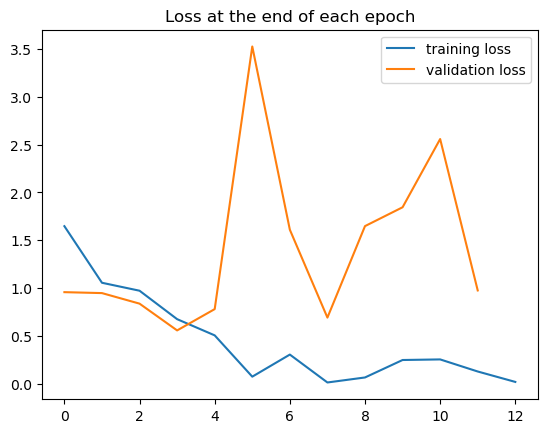

In [46]:
# Plot Losses

plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

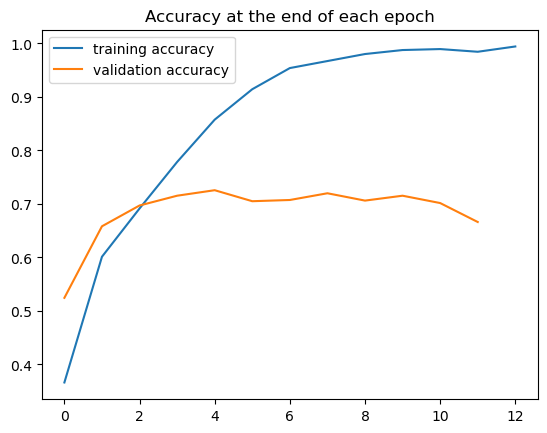

In [47]:
# Plot accuracy

plt.plot([t / 4957 for t in train_correct], label='training accuracy')
plt.plot([t / 875 for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [48]:
# How many accurate predictions were made per epoch

print("Train Correct:", train_correct)
print("\t")
print("Validation Correct:", validation_correct)

Train Correct: [tensor(1816), tensor(2981), tensor(3428), tensor(3859), tensor(4251), tensor(4533), tensor(4729), tensor(4794), tensor(4859), tensor(4896), tensor(4905), tensor(4880), tensor(4929)]
	
Validation Correct: [tensor(459), tensor(576), tensor(610), tensor(626), tensor(635), tensor(617), tensor(619), tensor(630), tensor(618), tensor(626), tensor(614), tensor(583)]


## Load saved model (custom CNN)

In [49]:
CNNmodel_best = ConvolutionalNetwork()
CNNmodel_best.load_state_dict(torch.load('BestCustomCNNModel.pt'))

<All keys matched successfully>

## Test the model (custom CNN)

In [54]:
# Test the model
test_correct = []
test_corr = 0

# Run the test batches
CNNmodel_best.eval()

with torch.no_grad():
    for batch, (images, labels) in enumerate(test_loader):

        # Apply the model for validation
        outputs = CNNmodel_best(images)
        loss = criterion(outputs, labels)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1] 
        test_corr += (predicted == labels).sum()
        
    accuracy = round(test_corr.item() * 100 / 1030, 3)

test_correct.append(test_corr)

In [55]:
# Evaluate test data

print("Test Correct:", test_correct)
print("Test Accuracy:", accuracy, "%")

Test Correct: [tensor(719)]
Test Accuracy: 69.806 %


## Confusion Matrix (custom CNN)

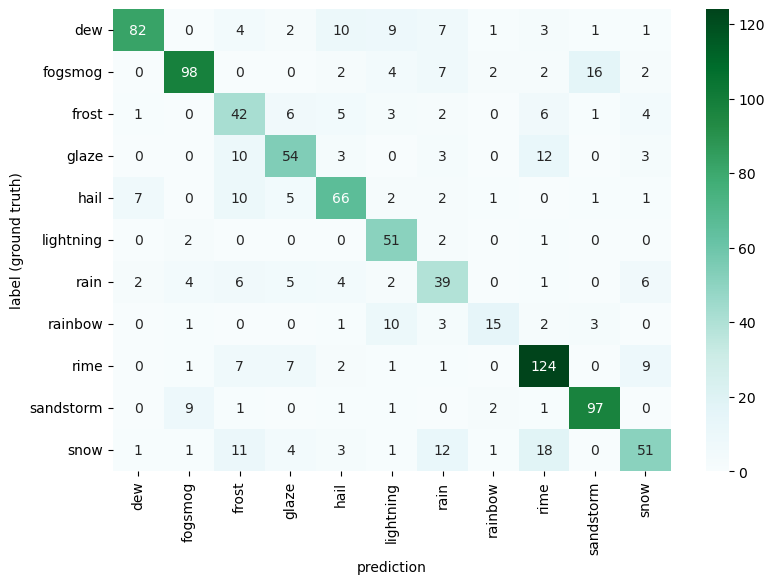

In [57]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=1030, shuffle=False)

with torch.no_grad():
    correct = 0
    for images, labels in test_load_all:
        outputs = CNNmodel_best(images)
        predicted = torch.max(outputs,1)[1]
        correct += (predicted == labels).sum()

arr = confusion_matrix(labels.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Loading AlexNet model

In [61]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [62]:
# We modified the classifier so that we have 11 output features in the last linear layer instead of 1000

AlexNetmodel.classifier[1] = nn.Linear(9216, 512)
AlexNetmodel.classifier[4] = nn.Linear(512, 256)
AlexNetmodel.classifier[6] = nn.Linear(256, 11)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=512, bias=True)
  

In [63]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

Sum of waits of the model:
	
   23232
      64
  307200
     192
  663552
     384
  884736
     256
  589824
     256
 4718592
     512
  131072
     256
    2816
      11
________
 7322955


In [64]:
criterion_AlexNet = nn.CrossEntropyLoss()
optimizer_AlexNet = torch.optim.AdamW(AlexNetmodel.classifier.parameters(), lr=0.001)

## Train model (AlexNet)

In [65]:
start_time = time.time()
epochs = 50

train_losses = []
train_correct = []
validation_losses = []
validation_correct = []

patience = 8
counter = 0
best_val_acc = 0
is_early_stop = False


for epoch in range(epochs):
    train_corr = 0
    validation_corr = 0
    
    # Run the training batches
    for batch, (images, labels) in enumerate(train_loader):

        # Apply the model for training
        outputs = AlexNetmodel(images)
        loss = criterion_AlexNet(outputs, labels)
 
        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        train_corr += (predicted == labels).sum()
        
        # Update parameters
        optimizer_AlexNet.zero_grad()
        loss.backward()
        optimizer_AlexNet.step()

    # Append losses and correct predictions per epoch
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    accuracy_train = round(train_corr.item() * 100 / 4957, 3)
    
    # Print each epoch results
    print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
          "Train accuracy:", accuracy_train, "%")


    
    
    # Run the validation batches
    AlexNetmodel.eval()
    
    with torch.no_grad():
        for batch, (images, labels) in enumerate(validation_loader):
            
            # Apply the model for validation
            outputs = AlexNetmodel(images)
            loss = criterion_AlexNet(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            validation_corr += (predicted == labels).sum()

        accuracy_val = round(validation_corr.item() * 100 / 875, 3)
        
            
        # Early stopping
        if accuracy_val > best_val_acc:
            best_val_acc = accuracy_val
            counter = 0
            torch.save(AlexNetmodel.state_dict(), 'BestAlexNetmodel.pt')
        else:
            counter += 1

        # Check for early stopping after the validation loop      
        if counter >= patience:
            is_early_stop = True
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                  "Validation accuracy:", accuracy_val, "%")            
            print("Early stopping triggered. Training stopped.")
            break
            
            
    # Append losses and correct predictions per epoch       
    validation_losses.append(loss)
    validation_correct.append(validation_corr)
        
    if is_early_stop:
        break
    else:
        # Print each epoch results
        print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
              "Validation accuracy:", accuracy_val, "%")
        print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
        print("\t")
    
    
print("\n")
print("Duration:", round(time.time() - start_time, 1), "seconds")

Epoch: 1 Train loss: 0.314 Train accuracy: 72.524 %
Epoch: 1 Validation loss: 0.954 Validation accuracy: 81.943 %
best_val_acc: 81.943 counter: 0
	
Epoch: 2 Train loss: 0.451 Train accuracy: 89.974 %
Epoch: 2 Validation loss: 1.145 Validation accuracy: 85.6 %
best_val_acc: 85.6 counter: 0
	
Epoch: 3 Train loss: 0.102 Train accuracy: 96.349 %
Epoch: 3 Validation loss: 0.004 Validation accuracy: 85.6 %
best_val_acc: 85.6 counter: 1
	
Epoch: 4 Train loss: 0.108 Train accuracy: 97.801 %
Epoch: 4 Validation loss: 0.042 Validation accuracy: 85.943 %
best_val_acc: 85.943 counter: 0
	
Epoch: 5 Train loss: 0.024 Train accuracy: 97.821 %
Epoch: 5 Validation loss: 1.429 Validation accuracy: 85.486 %
best_val_acc: 85.943 counter: 1
	
Epoch: 6 Train loss: 0.002 Train accuracy: 98.83 %
Epoch: 6 Validation loss: 0.213 Validation accuracy: 85.943 %
best_val_acc: 85.943 counter: 2
	
Epoch: 7 Train loss: 0.111 Train accuracy: 96.752 %
Epoch: 7 Validation loss: 0.184 Validation accuracy: 84.8 %
best_val_

## Evaluate model performance (AlexNet)

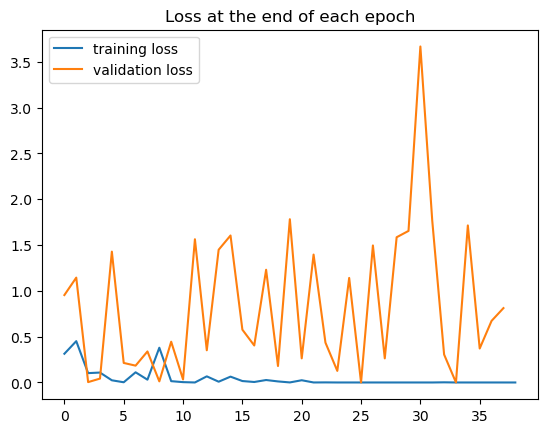

In [66]:
# Plot Losses

plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

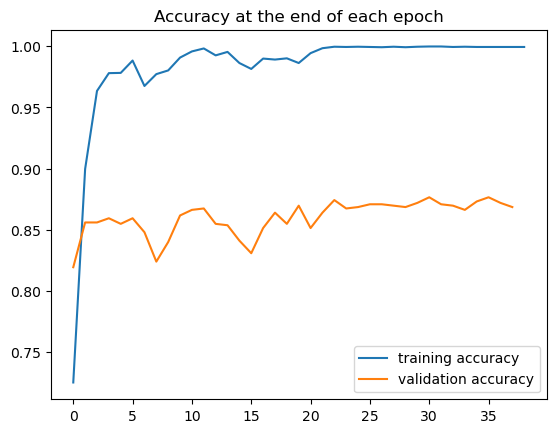

In [67]:
# Plot accuracy

plt.plot([t / 4957 for t in train_correct], label='training accuracy')
plt.plot([t / 875 for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [68]:
# How many accurate predictions were made per epoch

print("Train Correct:", train_correct)
print("\t")
print("Validation Correct:", validation_correct)

Train Correct: [tensor(3595), tensor(4460), tensor(4776), tensor(4848), tensor(4849), tensor(4899), tensor(4796), tensor(4844), tensor(4859), tensor(4911), tensor(4936), tensor(4948), tensor(4920), tensor(4934), tensor(4889), tensor(4865), tensor(4907), tensor(4903), tensor(4908), tensor(4889), tensor(4929), tensor(4949), tensor(4955), tensor(4954), tensor(4955), tensor(4954), tensor(4953), tensor(4955), tensor(4953), tensor(4955), tensor(4956), tensor(4956), tensor(4954), tensor(4955), tensor(4954), tensor(4954), tensor(4954), tensor(4954), tensor(4954)]
	
Validation Correct: [tensor(717), tensor(749), tensor(749), tensor(752), tensor(748), tensor(752), tensor(742), tensor(721), tensor(735), tensor(754), tensor(758), tensor(759), tensor(748), tensor(747), tensor(736), tensor(727), tensor(745), tensor(756), tensor(748), tensor(761), tensor(745), tensor(756), tensor(765), tensor(759), tensor(760), tensor(762), tensor(762), tensor(761), tensor(760), tensor(763), tensor(767), tensor(762),

## Test the model (AlexNet)

In [69]:
# Test the model
test_correct = []
test_corr = 0

# Run the test batches
AlexNetmodel.eval()

with torch.no_grad():
    for batch, (images, labels) in enumerate(test_loader):

        # Apply the model for validation
        outputs = AlexNetmodel(images)
        loss = criterion_AlexNet(outputs, labels)

        # number of correct predictions
        predicted = torch.max(outputs.data, 1)[1] 
        test_corr += (predicted == labels).sum()
        
    accuracy = round(test_corr.item() * 100 / 1030, 3)

test_correct.append(test_corr)

In [70]:
# Evaluate test data

print("Test Correct:", test_correct)
print("Test Accuracy:", accuracy, "%")

Test Correct: [tensor(879)]
Test Accuracy: 85.34 %


## Confusion Matrix (AlexNet)

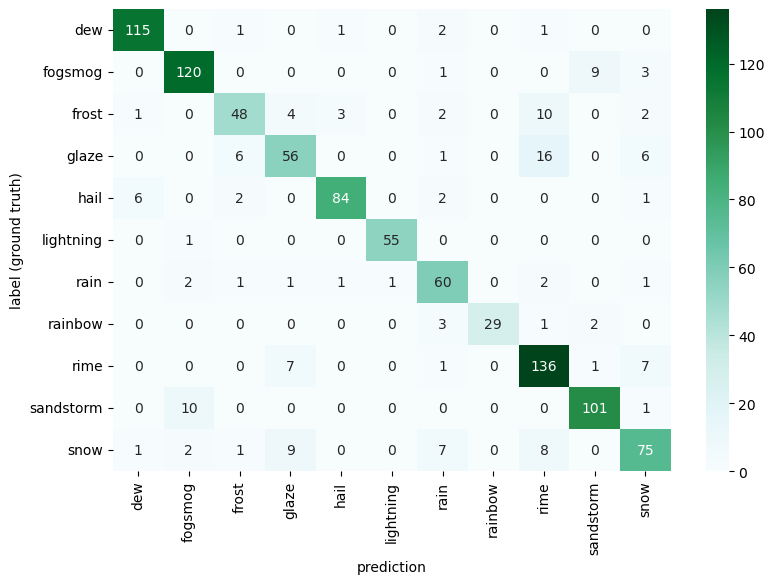

In [71]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=1030, shuffle=False)

with torch.no_grad():
    correct = 0
    for images, labels in test_load_all:
        outputs = AlexNetmodel(images)
        predicted = torch.max(outputs,1)[1]
        correct += (predicted == labels).sum()

arr = confusion_matrix(labels.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Open a custom image and use the models for prediction

Custom image size: torch.Size([3, 224, 224])
	
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Custom CNN model prediction: 5
	
AlexNet model prediction: 5


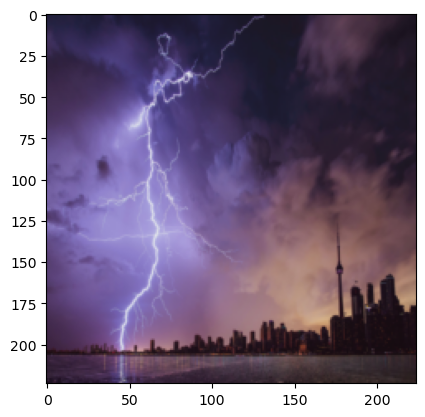

In [75]:
custom_img = Image.open('custom_images/4.jpg')

transform_custom = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

custom_img_t = transform_custom(custom_img)
print("Custom image size:", custom_img_t.shape)
print("\t")

custom_img_n = inv_normalize(custom_img_t)
plt.imshow(np.transpose(custom_img_n.numpy(), (1, 2, 0)));

print("Classes:", classes)
print("\t")

# CNN Model Prediction:
CNNmodel_best.eval()
with torch.no_grad():
    custom_pred = CNNmodel_best(custom_img_t.view(1,3,224,224)).argmax()
    
print("Custom CNN model prediction:", custom_pred.item())
print("\t")


# AlexNet Model Prediction:
AlexNetmodel.eval()
with torch.no_grad():
    custom_pred = AlexNetmodel(custom_img_t.view(1,3,224,224)).argmax()
    
print("AlexNet model prediction:", custom_pred.item())